## Import Libraries and Packages

In [1]:
import pandas as pd,numpy as np,matplotlib.pyplot as plt,seaborn as sns,plotly.express as px, datetime as dt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from sklearn.feature_selection import RFE, SelectFromModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')


# from google.colab import drive
# drive.mount('/content/drive')


## Data Loading

In [2]:
## Loading train data
#df = pd.read_csv("/content/drive/MyDrive/fraudTrain.csv")
df = pd.read_csv("fraudTrain.csv")
df.drop_duplicates(inplace=True)
#print(df.head(1))


In [3]:
df = df.drop(columns=[df.columns[0]])

## Feature Engineering

In [4]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
df['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
df['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
df['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month

## Exploratory Data Analysis

### 1. Univariate Analysis

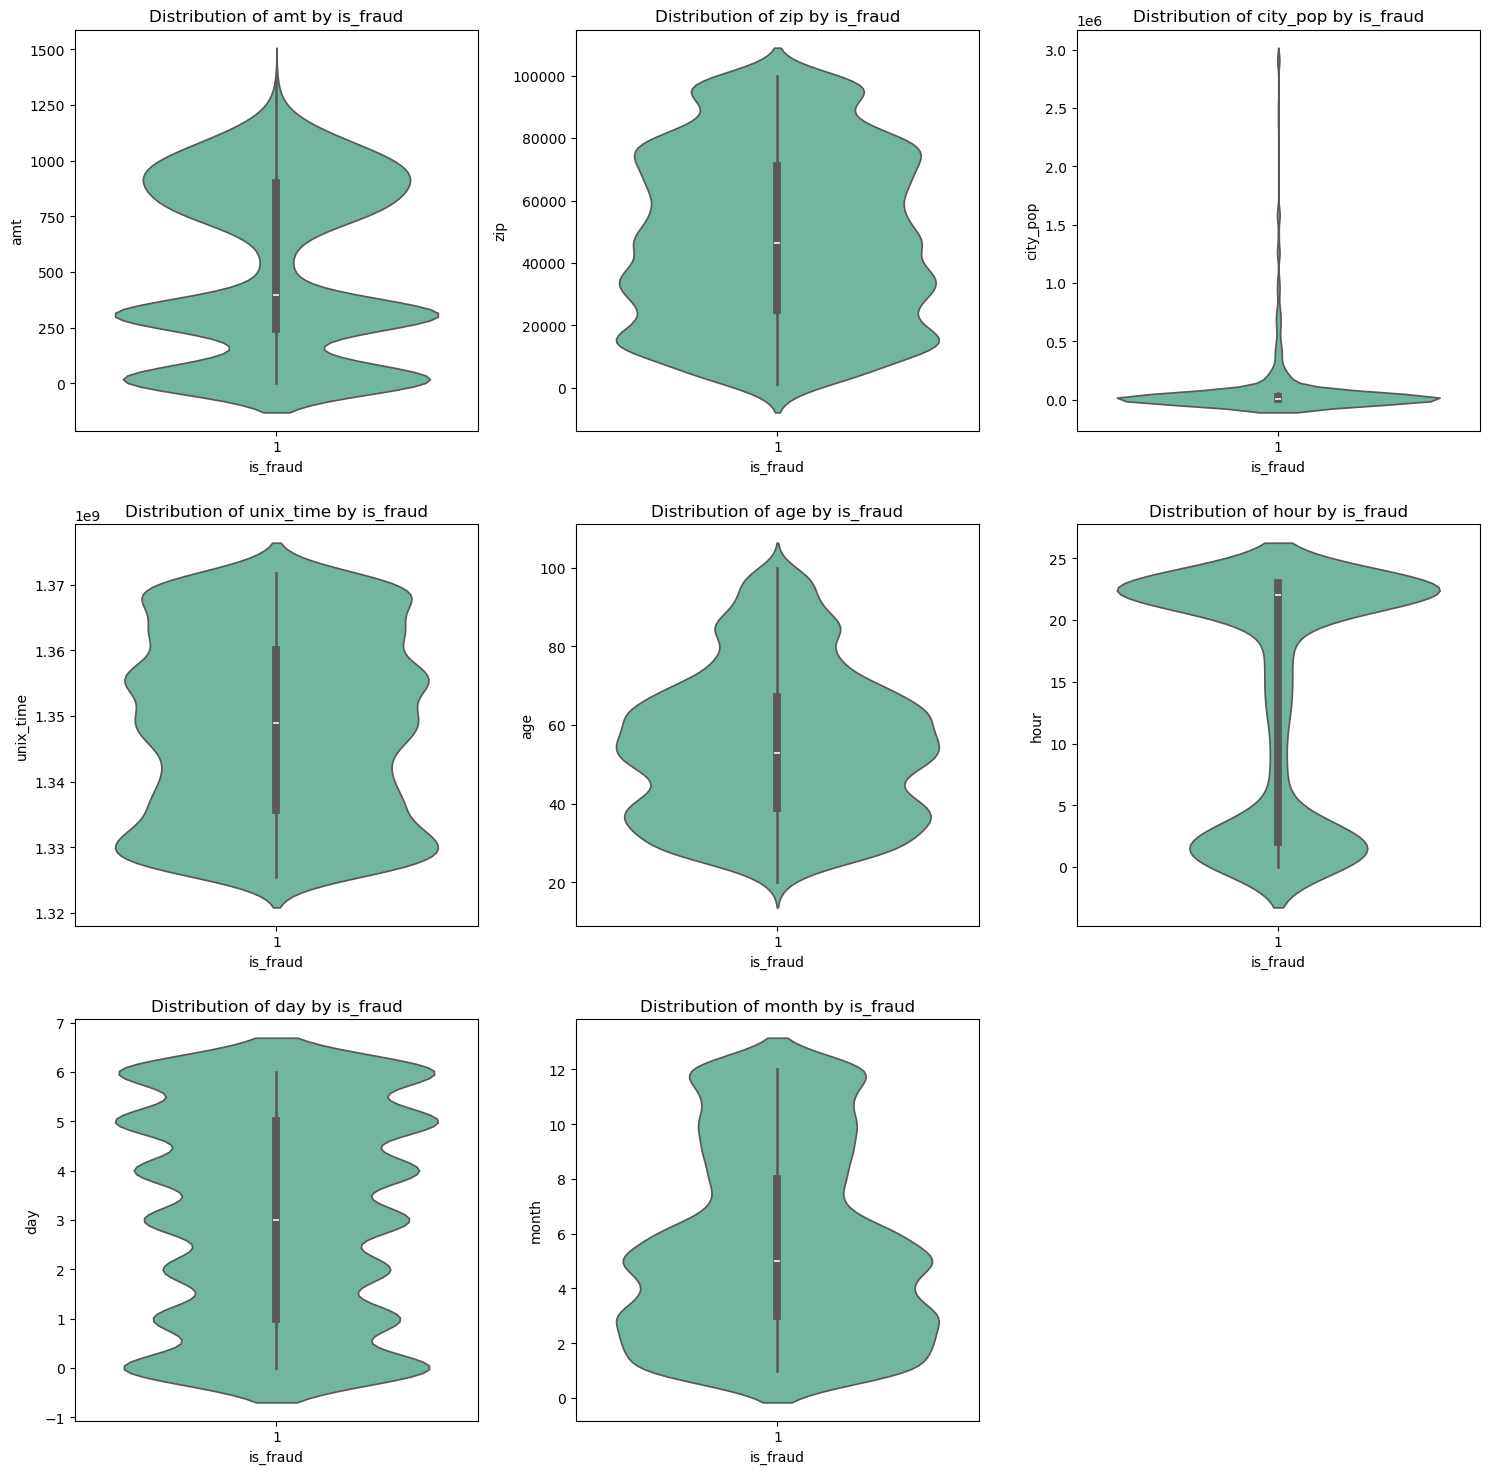

CPU times: user 1.55 s, sys: 2.29 s, total: 3.84 s
Wall time: 630 ms


In [5]:
%%time
# Define the target variable
target = 'is_fraud'

# Separate numeric features (excluding the target variable)
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.drop(target)
additional_features = np.array(['age', 'hour', 'day', 'month'])
exclude_features = np.array(['merch_lat', 'merch_long', 'cc_num','lat', 'long'])

final_features = [f for f in np.concatenate((numeric_features, additional_features)) if f not in exclude_features]

# Univariate analysis with the target variable
def univariate_analysis(df, numeric_features, target, cols=3):
    """
    Plots violin plots for each numeric feature against the target variable.
    """
    num_features = len(numeric_features)
    rows = -(-num_features // cols)  # Ceiling division
    
    # Create the figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    # Plot violin plots for numeric features
    for i, col in enumerate(final_features):
        sns.violinplot(x=target, y=col, data=df, ax=axes[i], palette="Set2")
        axes[i].set_title(f"Distribution of {col} by {target}")
        axes[i].set_xlabel(f"{target}")
        axes[i].set_ylabel(f"{col}")
    
    # Remove any unused subplots
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Call the univariate analysis function
univariate_analysis(df[df.is_fraud==1], final_features, target)


### 2. Bivariate Analysis

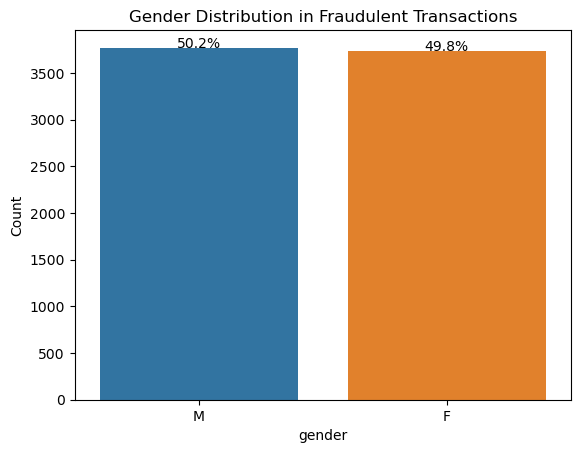

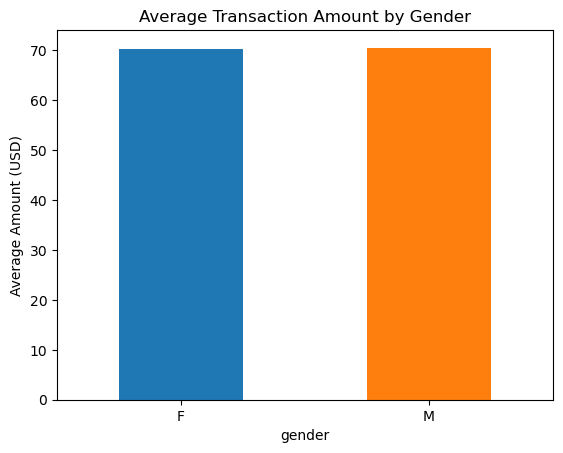

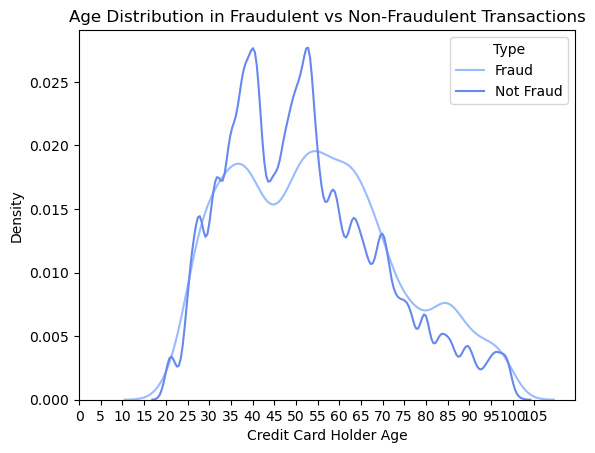

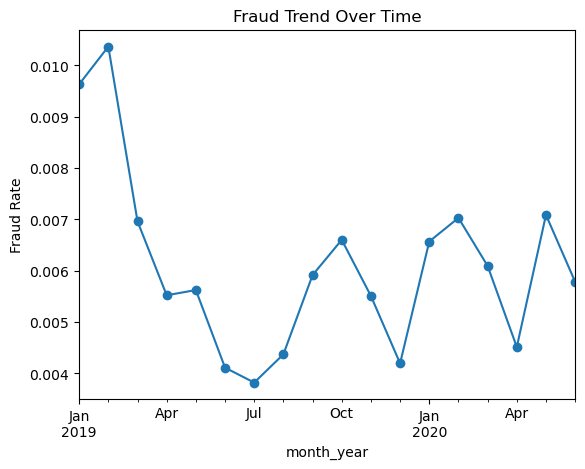

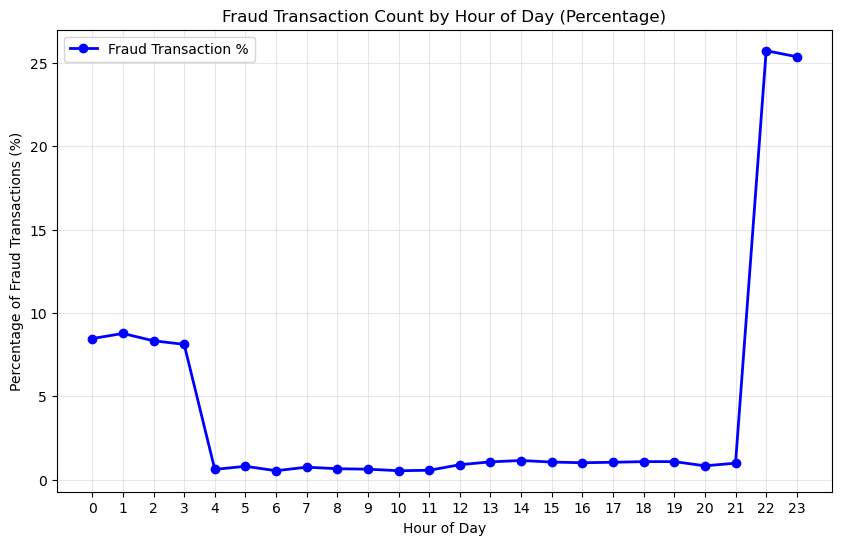

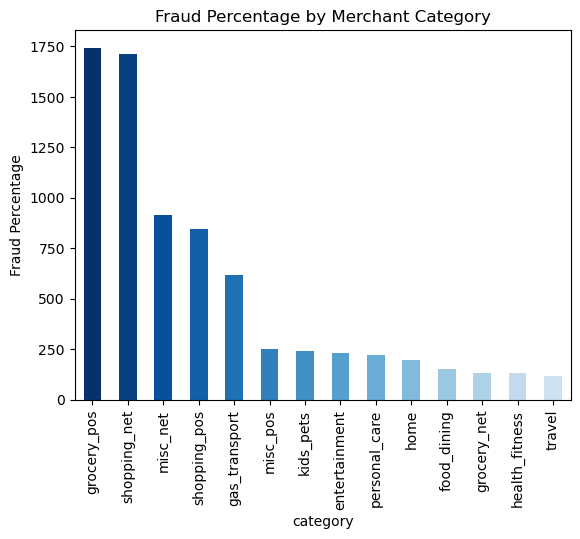

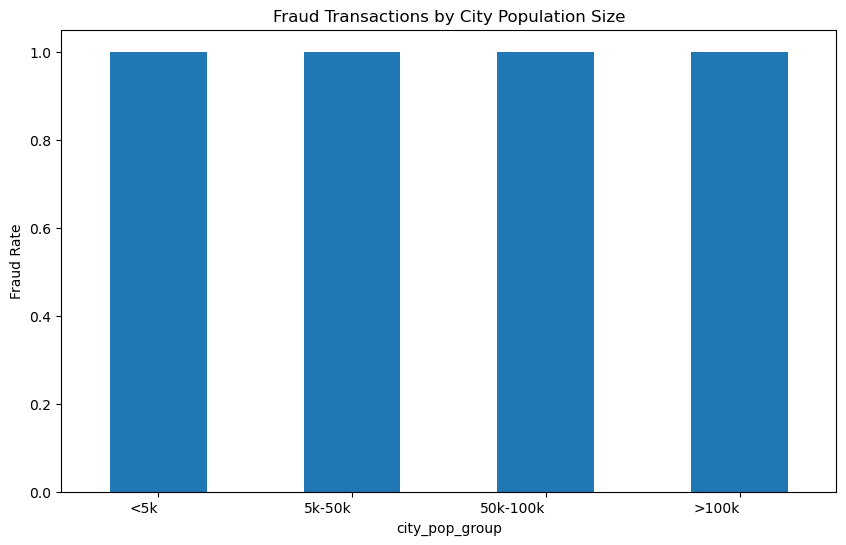

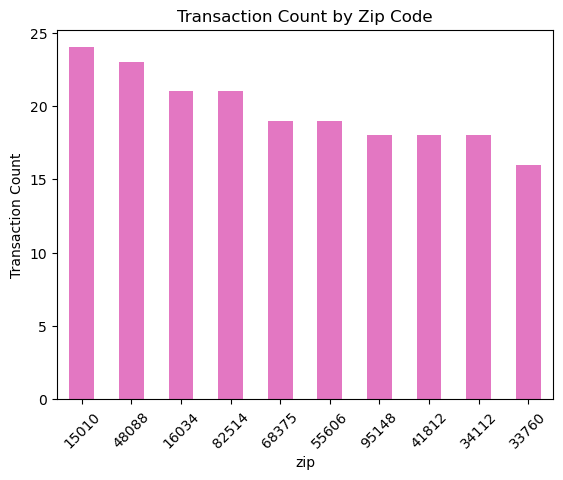

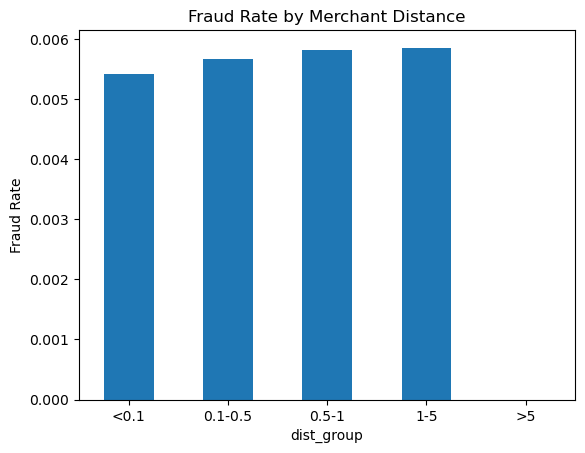

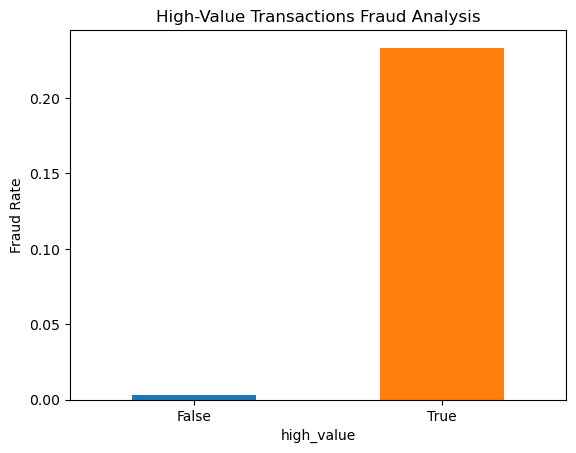

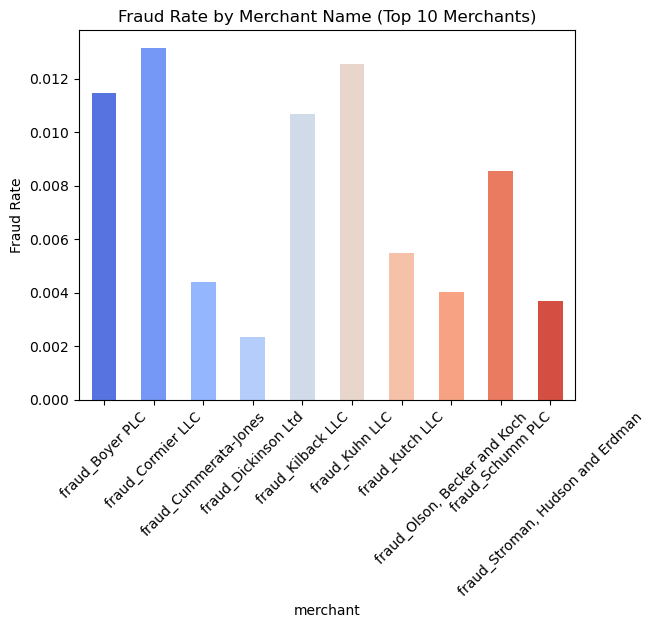

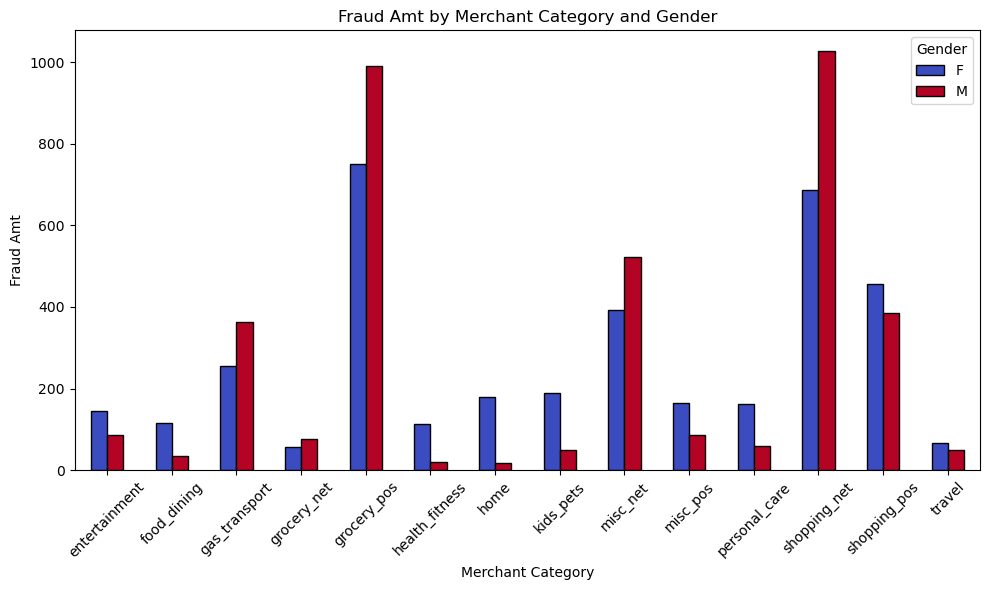

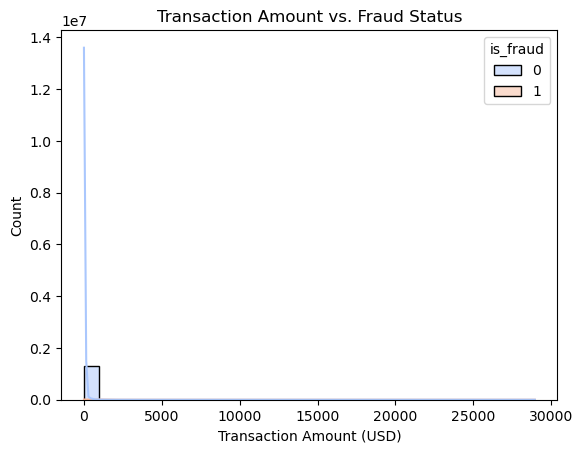

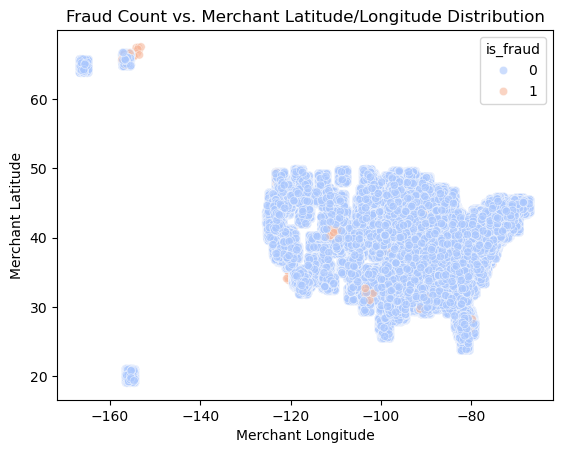

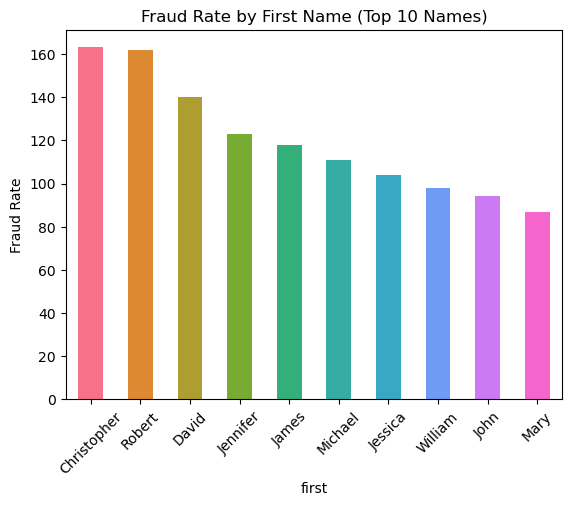

CPU times: user 21.9 s, sys: 6.31 s, total: 28.2 s
Wall time: 17 s


In [6]:
%%time
# Set a color palette for consistent styling
sns.set_palette("coolwarm")

# 1. Gender Distribution in Fraudulent Transactions
sns.countplot(
    x='gender',
    data=df[df.is_fraud == 1],
    palette={'M':'#1f77b4','F': '#ff7f0e'},hue='gender')
for index, count in enumerate(df[df.is_fraud == 1]['gender'].value_counts()):
    plt.text(index, count + 0.5, f"{(count / len(df[df.is_fraud == 1]) * 100):.1f}%", ha='center', fontsize=10)
plt.title('Gender Distribution in Fraudulent Transactions')
plt.ylabel('Count')
plt.show()

# 2. Average Transaction Amount by Gender
gender_amt = df.groupby('gender')['amt'].mean()
gender_amt.plot(kind='bar', title='Average Transaction Amount by Gender', color=['#1f77b4', '#ff7f0e'], rot=0)
plt.ylabel('Average Amount (USD)')
plt.show()

# 3. Fraud Rate by Age Group
ax = sns.kdeplot(x='age', data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 5))
plt.title('Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])
plt.show()


# 4. Fraud Trend Over Time (By Month/Year)
df['month_year'] = df['trans_date_trans_time'].dt.to_period('M')
fraud_trend = df.groupby('month_year')['is_fraud'].mean()
fraud_trend.plot(kind='line', title='Fraud Trend Over Time', color='#1f77b4', marker='o')
plt.ylabel('Fraud Rate')
plt.show()

# 5. Transaction Count by Hour of Day
df['hour'] = df['trans_date_trans_time'].dt.hour
hourly_fraud_trans = df[df['is_fraud'] == 1]['hour'].value_counts(normalize=True).sort_index() * 100
plt.figure(figsize=(10, 6))
plt.plot(hourly_fraud_trans.index, hourly_fraud_trans.values, marker='o', linestyle='-', color='blue', linewidth=2, label='Fraud Transaction %')
plt.xticks(hourly_fraud_trans.index)
plt.title('Fraud Transaction Count by Hour of Day (Percentage)')
plt.ylabel('Percentage of Fraud Transactions (%)')
plt.xlabel('Hour of Day')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 6. Fraud Percentage by Merchant Category
category_fraud = df.groupby('category')['is_fraud'].sum().sort_values(ascending=False)
category_fraud = category_fraud.sort_values(ascending=False)
colors = plt.cm.Blues(np.linspace(1, 0.2, len(category_fraud)))
category_fraud.plot(kind='bar', title='Fraud Percentage by Merchant Category', color=colors)
plt.ylabel('Fraud Percentage')
plt.show()

# 7. Fraud Percentage by State
state_fraud = (df[(df['state'] != 'DE')&(df['is_fraud']==1)].groupby('state').apply(lambda x: x['is_fraud'].mean()).nlargest(10))
colors = plt.cm.viridis(np.linspace(0.4, 1, len(state_fraud)))
state_fraud.plot(kind='bar',title='Fraud Percentage by State (Top 10, Excluding DE)',color=colors,figsize=(10, 6),ylabel='Fraud Percentage')
plt.xlabel('State')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 8. Fraud Transactions by City Population Size
df['city_pop_group'] = pd.cut(df['city_pop'], bins=[0, 5000, 50000, 100000, 1000000], labels=['<5k', '5k-50k', '50k-100k', '>100k'])
city_pop_fraud = df[df.is_fraud==1].groupby('city_pop_group')['is_fraud'].mean()
city_pop_fraud.plot(kind='bar', title='Fraud Transactions by City Population Size', color='#1f77b4', rot=0)
plt.ylabel('Fraud Rate')
plt.show()

# 9. Transaction Count by Zip Code
zip_trans_count = df[df.is_fraud==1]['zip'].value_counts().head(10)
zip_trans_count.plot(kind='bar', title='Transaction Count by Zip Code', color='#e377c2', rot=45)
plt.ylabel('Transaction Count')
plt.show()

# 10. Fraud Rate by Merchant Latitude/Longitude Distance from Cardholder
df['dist'] = ((df['merch_lat'] - df['lat'])**2 + (df['merch_long'] - df['long'])**2)**0.5
df['dist_group'] = pd.cut(df['dist'], bins=[0, 0.1, 0.5, 1, 5, 10], labels=['<0.1', '0.1-0.5', '0.5-1', '1-5', '>5'])
dist_fraud = df.groupby('dist_group')['is_fraud'].mean()
dist_fraud.plot(kind='bar', title='Fraud Rate by Merchant Distance', color='#1f77b4', rot=0)
plt.ylabel('Fraud Rate')
plt.show()

# 11. High-Value Transactions Fraud Analysis
df['high_value'] = df['amt'] > 500
high_value_fraud = df.groupby('high_value')['is_fraud'].mean()
high_value_fraud.plot(kind='bar', title='High-Value Transactions Fraud Analysis', color=['#1f77b4', '#ff7f0e'], rot=0)
plt.ylabel('Fraud Rate')
plt.show()

# 12. Fraud Rate by Merchant Name (Top 10 Merchants)
top_merchants = df['merchant'].value_counts().head(10).index
merchant_fraud = df[df['merchant'].isin(top_merchants)].groupby('merchant')['is_fraud'].mean()
merchant_fraud.plot(kind='bar', title='Fraud Rate by Merchant Name (Top 10 Merchants)', color=sns.color_palette("coolwarm", len(top_merchants)), rot=45)
plt.ylabel('Fraud Rate')
plt.show()

# 13. Gender-Based Fraud Rate Across Merchant Categories
gender_fraud = df[df.is_fraud==1].groupby(['category', 'gender'])['is_fraud'].sum().unstack()
gender_fraud.plot(kind='bar', figsize=(10, 6), colormap='coolwarm', edgecolor='black')
plt.title('Fraud Amt by Merchant Category and Gender')
plt.ylabel('Fraud Amt')
plt.xlabel('Merchant Category')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# 14. Transaction Amount vs. Fraud Status
sns.histplot(data=df, x='amt', hue='is_fraud', bins=30, kde=True, palette='coolwarm')
plt.title('Transaction Amount vs. Fraud Status')
plt.xlabel('Transaction Amount (USD)')
plt.show()

# 15. Fraud Count vs. Merchant Latitude/Longitude Distribution
sns.scatterplot(data=df, x='merch_long', y='merch_lat', hue='is_fraud', alpha=0.6, palette='coolwarm')
plt.title('Fraud Count vs. Merchant Latitude/Longitude Distribution')
plt.xlabel('Merchant Longitude')
plt.ylabel('Merchant Latitude')
plt.show()

# 16. Fraud Rate by First Name (Top 10 Names)
top_names = df['first'].value_counts().head(10).index
name_fraud = df[df['first'].isin(top_names)].groupby('first')['is_fraud'].sum().sort_values(ascending=False)
colors = sns.color_palette("husl", len(top_names))
name_fraud.plot(kind='bar', title='Fraud Rate by First Name (Top 10 Names)', color=colors, rot=45)
plt.ylabel('Fraud Rate')
plt.show()



### Correlation Matrix & Feature Importance

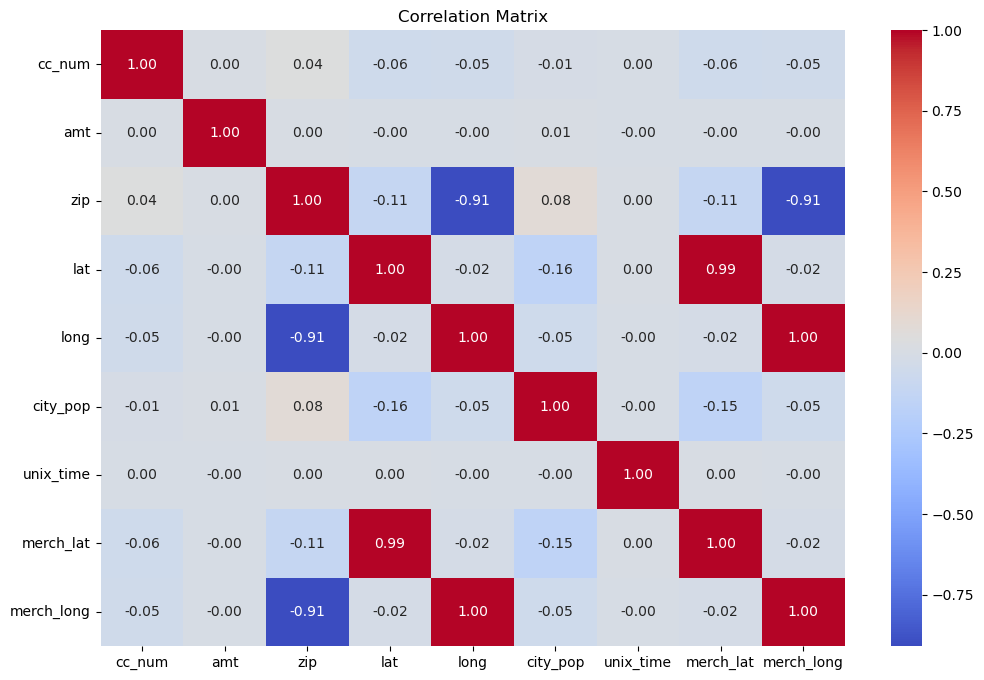

In [7]:
def correlation_analysis(df, target, numeric_features):
    # Calculate correlation matrix
    correlation_matrix = df[numeric_features].corr()

    # Plot heatmap for correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

# Call the correlation analysis function
correlation_analysis(df, target, numeric_features)

## Modeling

In [8]:
%%time
#subset the training data to include only the features that we need
train=df[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]
#convert category to dummy variables
train=pd.get_dummies(train, drop_first=True)
y_train=train['is_fraud'].values
X_train=train.drop("is_fraud", axis='columns').values

#let's do the same to the testing dataset
#test=pd.read_csv('/content/drive/MyDrive/fraudTest.csv')
test=pd.read_csv('fraudTest.csv')
test['age']=dt.date.today().year-pd.to_datetime(test['dob']).dt.year
test['hour']=pd.to_datetime(test['trans_date_trans_time']).dt.hour
test['day']=pd.to_datetime(test['trans_date_trans_time']).dt.dayofweek
test['month']=pd.to_datetime(test['trans_date_trans_time']).dt.month
test=test[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]
#convert category to dummy variables
test=pd.get_dummies(test, drop_first=True)
y_test=test['is_fraud'].values
X_test=test.drop("is_fraud", axis='columns').values

CPU times: user 2.24 s, sys: 344 ms, total: 2.59 s
Wall time: 2.37 s


## Imbalanced Data Treatment

In [8]:
from imblearn.over_sampling import SMOTE

method= SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

### Model 1: Logistic Regression

In [9]:
%%time

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(X_resampled,y_resampled)
lr_predictions=lr.predict(X_test)
print('Classification report:\n', classification_report(y_test, lr_predictions))
lr_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=lr_predictions)
print('Confusion matrix:\n', lr_confusion_matrix)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))


Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97    553574
           1       0.05      0.75      0.10      2145

    accuracy                           0.95    555719
   macro avg       0.53      0.85      0.54    555719
weighted avg       1.00      0.95      0.97    555719

Confusion matrix:
 [[525788  27786]
 [   537   1608]]
Share of Non-Fraud in Test Data: 0.9961
CPU times: user 1min 5s, sys: 27.2 s, total: 1min 32s
Wall time: 13.4 s


### Model 2: Random Forest

In [10]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=5)
rf.fit(X_resampled,y_resampled)
rf_predictions=rf.predict(X_test)
print('Classification report:\n', classification_report(y_test, rf_predictions))
rf_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=rf_predictions)
print('Confusion matrix:\n', rf_confusion_matrix)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.88      0.73      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.86      0.90    555719
weighted avg       1.00      1.00      1.00    555719

Confusion matrix:
 [[553364    210]
 [   585   1560]]
Share of Non-Fraud in Test Data: 0.9961
CPU times: user 7min 25s, sys: 4.78 s, total: 7min 30s
Wall time: 7min 33s


## Conclusion

1. Random Forest is the better model overall for fraud detection due to its high precision and balanced F1-score.
2. Fine-tuning the threshold for Random Forest can improve recall without sacrificing much precision when catching more fraud cases is a priority.